In [1]:
# todo: check the model cfg: augmentations, policy

In [1]:
import numpy as np

import torch
from torch import nn
from utils import parse_cfg
from darknet import Darknet

In [2]:
darknet = Darknet('cfg/yolov3.cfg')

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch


In [4]:
x = torch.randn((2, 3, 608, 608))
darknet.forward(x, 'cpu').shape
# todo what is after .forward

/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([2, 22743, 85])

(452, 602, 3)


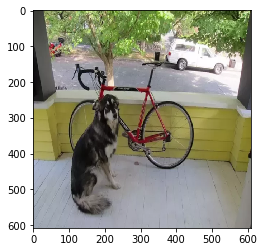

torch.Size([1, 3, 608, 608])


/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/miniconda3/envs/main/lib/python3.5/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor([[[ 0.5584,  0.4951,  2.6899,  ...,  0.5148,  0.5482,  0.4956],
         [ 0.5108,  0.4646,  5.7767,  ...,  0.4925,  0.4930,  0.5552],
         [ 0.4227,  0.4842, 10.3724,  ...,  0.4609,  0.4759,  0.5100],
         ...,
         [75.4608, 75.5091,  1.0658,  ...,  0.4984,  0.5548,  0.4620],
         [75.5016, 75.4787,  1.6984,  ...,  0.5255,  0.5595,  0.5106],
         [75.5311, 75.4898,  4.2641,  ...,  0.5122,  0.5737,  0.4880]]],
       grad_fn=<CatBackward>)

In [28]:
from matplotlib import pyplot as plt
import cv2

plt.figure()
img = cv2.imread('dog-cycle-car.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
img = cv2.resize(img, (608, 608)) / 255
plt.imshow(img)
plt.show()
img = img.transpose((2, 0, 1))
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)
print(img.shape)
pred = darknet.forward(img, 'cpu')
pred

In [33]:
weight_file = 'weights/yolov3.weights'
self_layers_info = darknet.layers_info
self_net_info, self_layers_list = darknet.net_info, darknet.layers_list

In [37]:
r_file = open(weight_file, 'rb')
# header consists on version numbers (major, minor, subversion)
# and number of images seen by model during training
header = np.fromfile(r_file, dtype=np.int32, count=5)
# the rest are weights in a form of a vector (not matrix)
weights = np.fromfile(r_file, dtype=np.float32)

for i, layer in enumerate(self_layers_list):
    # i+1 because 0th is net_info
    name = self_layers_info[i+1]['name']
    
    if name == 'convolutional':
        
        try:
            self_layers_info[i+1]['batch_normalize']
            conv, bn = self_layers_list[i][:2]
            print(conv, bn)
            # todo
            
        except KeyError:
            print('no bn detected at {}'.format(i))
            pass
            
    if i == 0:
        break

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [4]:
sum(p.numel() for p in darknet.parameters() if p.requires_grad)

61975453

In [39]:
weights.shape # 61949149

(62001757,)